<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#XGBRegressor" data-toc-modified-id="XGBRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>XGBRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Выбор-модели" data-toc-modified-id="Выбор-модели-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Выбор модели</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Входные данные:**

- исторические данные о заказах такси в аэропортах компании «Чётенькое такси»:

https://code.s3.yandex.net/datasets/taxi.csv

**Целевой признак:**

`num_orders` — Количество заказов

**Условия задачи:**

- Значение метрики RMSE на тестовой выборке должно быть не больше 48
        
**Цель исследования:**
        
- Построить модель для предсказания количества заказов такси на следующий час 

**Задачи:**

- Загрузить данные и выполнить их ресемплирование по одному часу.

- Проанализировать данные.

- Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.

- Проверить данные на тестовой выборке и сделать выводы.

**Этапы исследования:**

- Подготовка данных

- Анализ

- Обучение моделей

- Тестирование

- Общий вывод

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.head()

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.describe().T

count       mean      std  min  25%   50%   75%    max
num_orders  26496.0  14.070463  9.21133  0.0  8.0  13.0  19.0  119.0

In [6]:
df.isna().sum()

num_orders    0
dtype: int64

In [7]:
df.index.is_monotonic

True

Даты и время расположены в хронологическом порядке.

Отсортируем индекс таблицы

In [8]:
df.sort_index(inplace=True)

Ресемплируем данные по одному часу

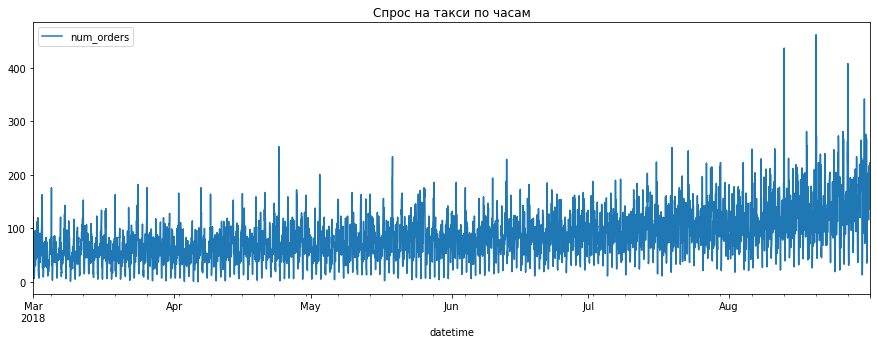

In [9]:
df = df.resample('1H').sum()
df.plot(figsize=(15,5))
plt.title('Спрос на такси по часам')
plt.show()

Посмотрим за какой период данные

In [10]:
df.index.min(), df.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

### Вывод

- Данные в таблице: с 1 марта 2018 года по 31 августа 2018 года

- Пропусков нет.

- Всего один признак: `num_orders`.

- временной интервал: 10 минут.

- Даты и время расположены в хронологическом порядке, индекс отсортировали.

## Анализ

Разложим данные на тренд, сезонность и остаток.

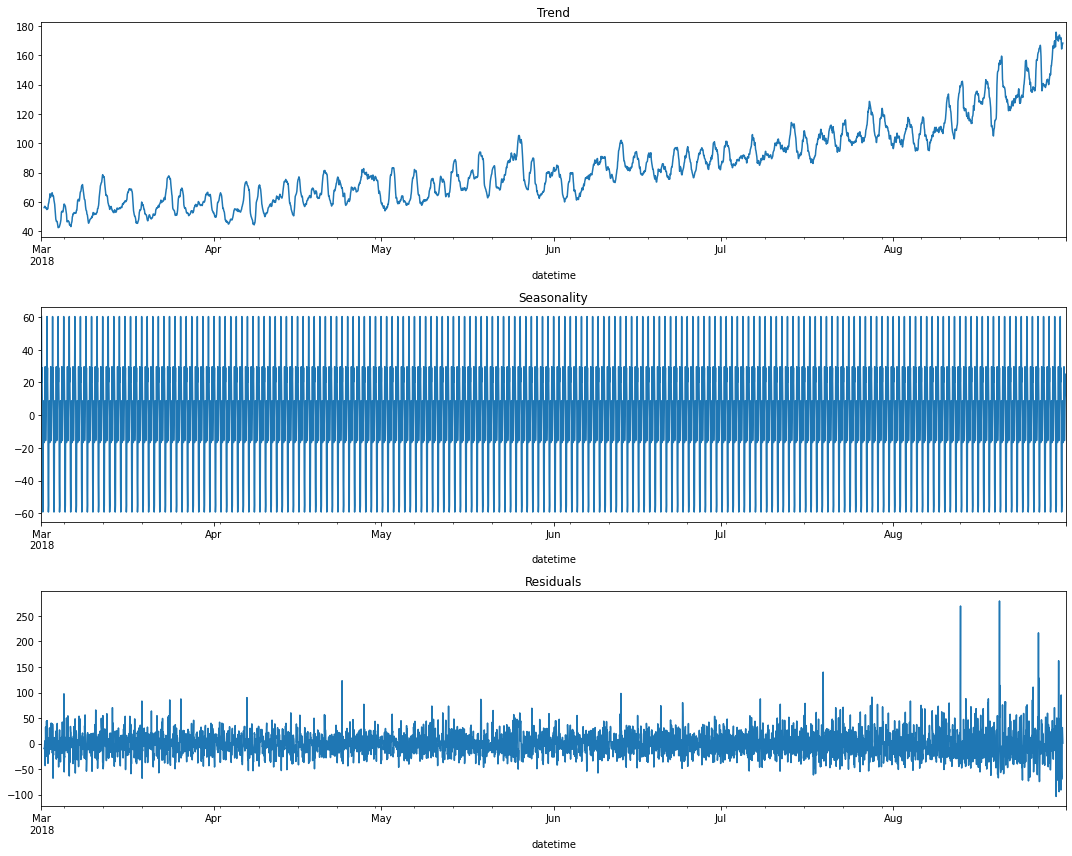

In [11]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

**За последний месяц**

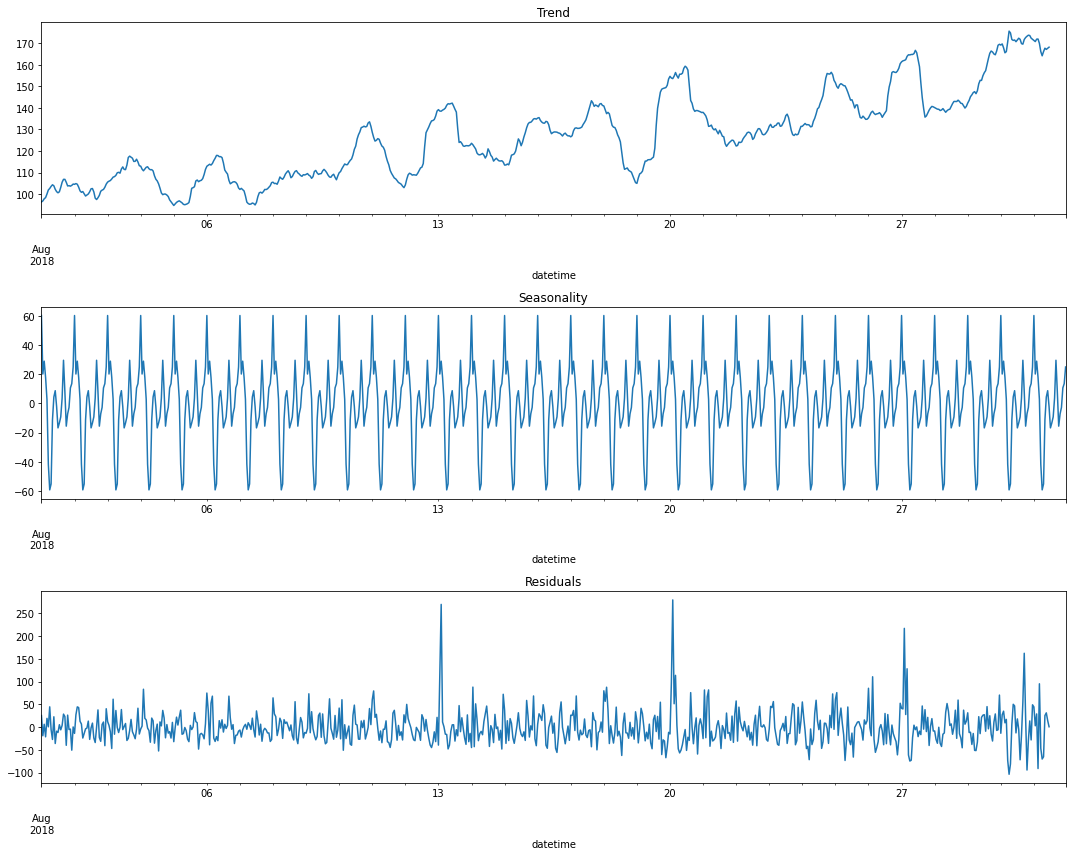

In [12]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 12))

plt.subplot(311)
decomposed.trend['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

**За последнюю неделю**

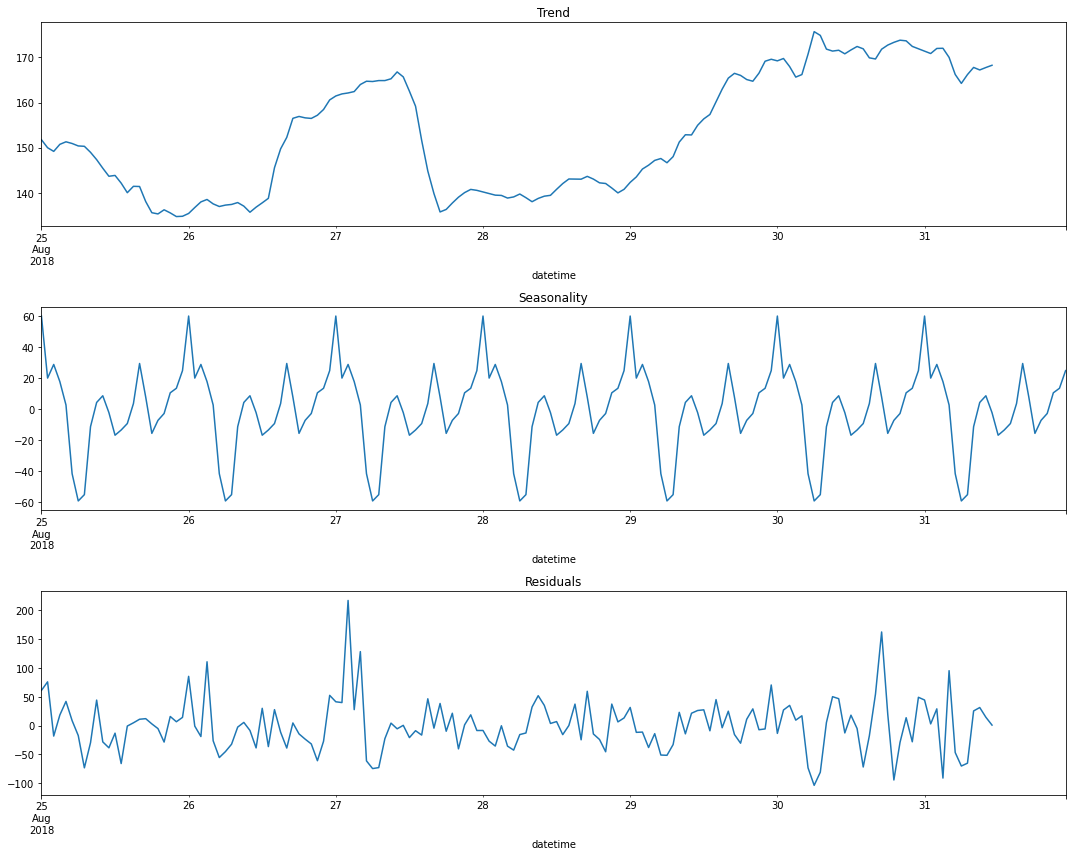

In [13]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 12))

plt.subplot(311)
decomposed.trend['2018-08-25':'2018-08-31'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-08-25':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid['2018-08-25':'2018-08-31'].plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

**За последние 2 дня**

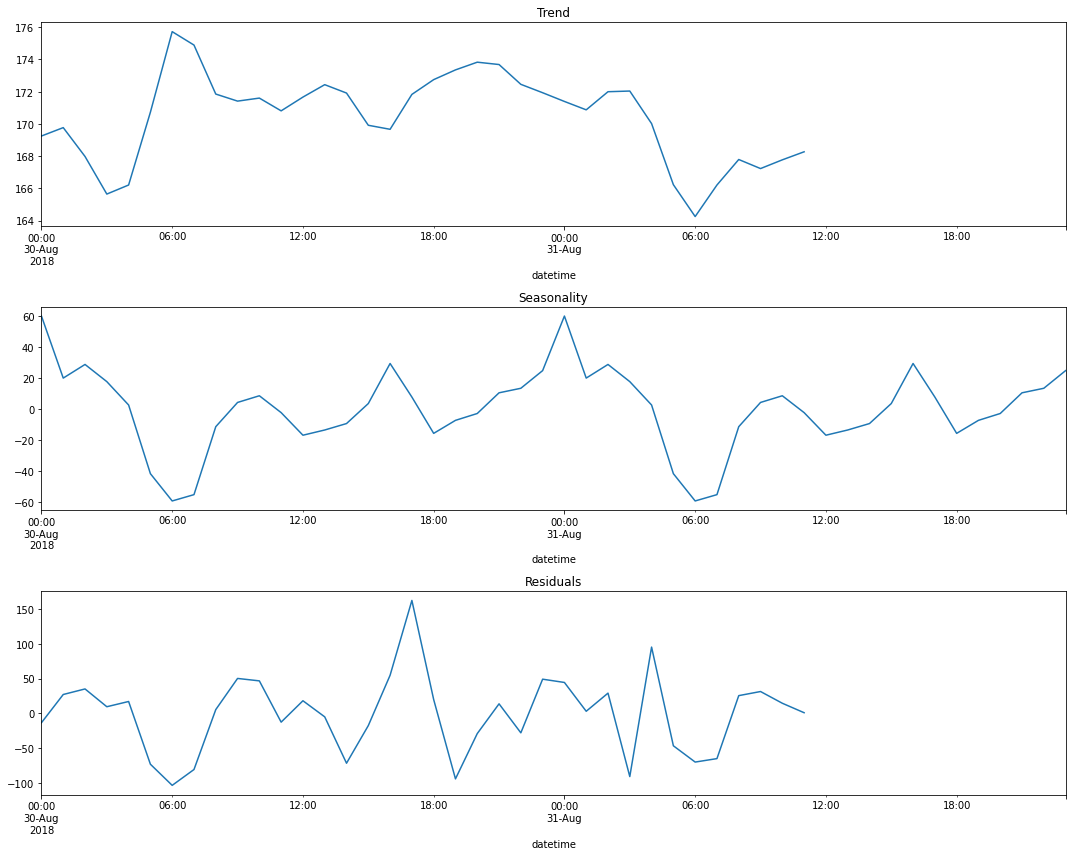

In [14]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 12))

plt.subplot(311)
decomposed.trend['2018-08-30':'2018-08-31'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-08-30':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid['2018-08-30':'2018-08-31'].plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

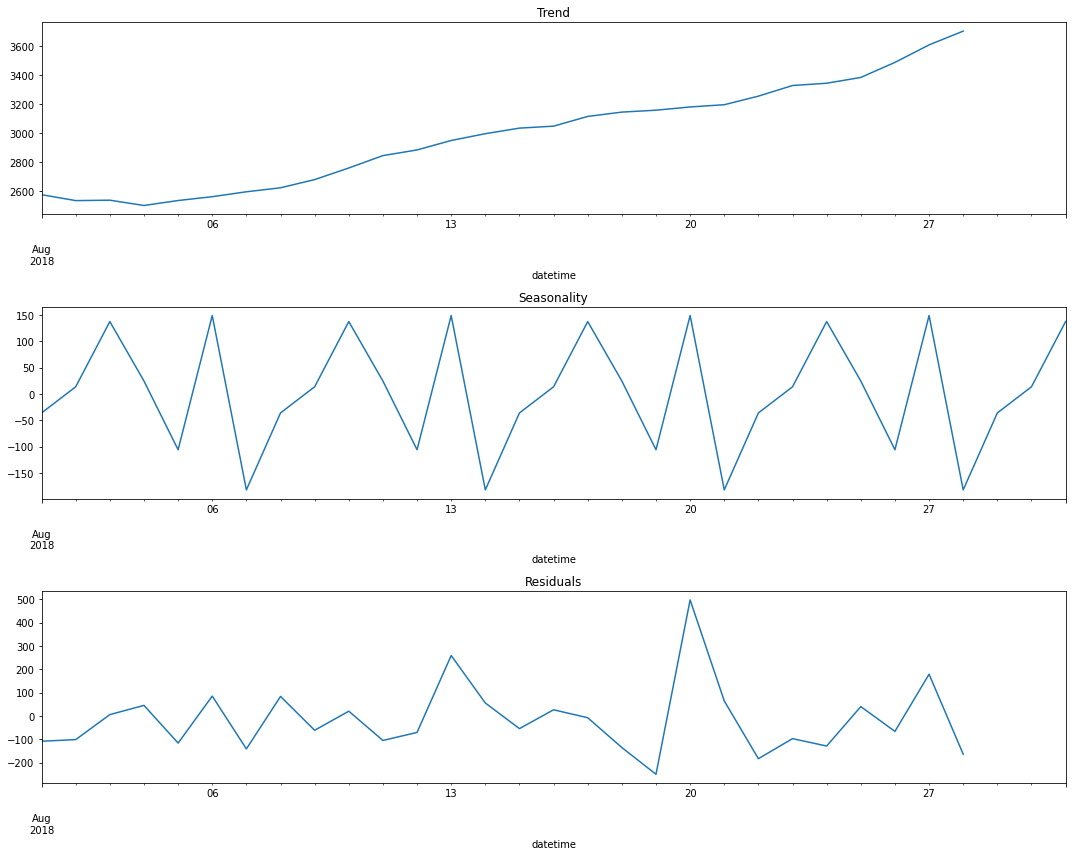

In [15]:
df_day = df.resample('1D').sum()
decomposed = seasonal_decompose(df_day)

plt.figure(figsize=(15, 12))

plt.subplot(311)
decomposed.trend['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

### Вывод

**trend**

- За все время: спрос на такси в летние месяцы растет, относительно весенних.

- За последний месяц: Спрос растет к концу месяца. Окончание сезона отпусков.

- За последнюю неделю: Высокий спрос в сб, пн и последние дни августа (30 и 31го). Окончание сезона отпусков и летних каникул.

**Seasonality**

- Сезонность заметна во все периоды. Для нас наиболее важна за последние 2 дня, с данными по часам, т.к. предсказать нам предстоит количество заказов на следующий час.

**Residuals**

- Во всех периодах прослеживаются пики роста спроса.


Чтобы во временном ряду снизить колебания, применим скользящее среднее.

## Обучение

### Подготовка данных

Напишем функцию для создания признаков. Разберём каждый тип признаков: 

1. Календарные признаки. Возьмем месяц, день (праздники, конец отпусков и прочие аномалии), день недели (будни и выходные),час.

2. Отстающие значения. Предыдущие значения временного ряда подскажут, будет ли функция расти или уменьшаться.

3. Скользящее среднее. 

In [16]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_sum'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [17]:
df_features = make_features(df, 10, 10)
df_features.head()

num_orders  dayofweek  hour  lag_1  lag_2  lag_3  lag_4  \
datetime                                                                       
2018-03-01 00:00:00         124          3     0    NaN    NaN    NaN    NaN   
2018-03-01 01:00:00          85          3     1  124.0    NaN    NaN    NaN   
2018-03-01 02:00:00          71          3     2   85.0  124.0    NaN    NaN   
2018-03-01 03:00:00          66          3     3   71.0   85.0  124.0    NaN   
2018-03-01 04:00:00          43          3     4   66.0   71.0   85.0  124.0   

                     lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  rolling_sum  
datetime                                                                     
2018-03-01 00:00:00    NaN    NaN    NaN    NaN    NaN     NaN          NaN  
2018-03-01 01:00:00    NaN    NaN    NaN    NaN    NaN     NaN          NaN  
2018-03-01 02:00:00    NaN    NaN    NaN    NaN    NaN     NaN          NaN  
2018-03-01 03:00:00    NaN    NaN    NaN    NaN    NaN     NaN          NaN  
2018-03-01 04:00:00    NaN    NaN    NaN    NaN    NaN     NaN          NaN

Разделим данные на выборки

In [18]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

### XGBRegressor

In [19]:
%%time

model_xgb = XGBRegressor()

param_grid = {'max_depth': range(5, 10), 'n_estimators': range(100, 300, 50)}
cv = TimeSeriesSplit(n_splits=3).split(features_train)
grid_xgb =  GridSearchCV(model_xgb, param_grid, scoring='neg_mean_squared_error', cv=cv)
grid_xgb.fit(features_train, target_train)
rmse_xgb = (grid_xgb.best_score_*-1) ** 0.5

grid_xgb.best_params_, rmse_xgb

CPU times: user 7min 21s, sys: 2.85 s, total: 7min 24s
Wall time: 7min 28s


({'max_depth': 6, 'n_estimators': 150}, 28.595371718989245)

### LGBMRegressor

In [20]:
%%time

model_lgbm = LGBMRegressor()

param_grid = {'max_depth': range(10, 15), 'n_estimators': range(35, 40)}
cv = TimeSeriesSplit(n_splits=3).split(features_train)
grid_lgbm = GridSearchCV(model_lgbm, param_grid, scoring='neg_mean_squared_error', cv=cv)
grid_lgbm.fit(features_train, target_train)
rmse_lgbm = (grid_lgbm.best_score_*-1) ** 0.5

grid_lgbm.best_params_, rmse_lgbm

CPU times: user 28 s, sys: 283 ms, total: 28.3 s
Wall time: 28.5 s


({'max_depth': 10, 'n_estimators': 39}, 27.528703425359208)

### CatBoostRegressor

In [22]:
model_cbr = CatBoostRegressor(random_state=42)

param_grid = {'max_depth': range(1, 10), 'n_estimators': range(100, 500, 50)}
cv = TimeSeriesSplit(n_splits=3).split(features_train)
grid_cbr = GridSearchCV(model_cbr, param_grid, verbose=False, cv=cv, scoring='neg_mean_squared_error')
grid_cbr.fit(features_train, target_train)
rmse_cbr = (grid_cbr.best_score_*-1) ** 0.5

grid_cbr.best_params_, rmse_cbr

Learning rate set to 0.265803
0:	learn: 28.0881742	total: 46.4ms	remaining: 4.59s
1:	learn: 27.0022050	total: 46.8ms	remaining: 2.29s
2:	learn: 26.4578397	total: 47.1ms	remaining: 1.52s
3:	learn: 25.7582904	total: 47.4ms	remaining: 1.14s
4:	learn: 25.1093169	total: 47.7ms	remaining: 906ms
5:	learn: 24.5813833	total: 48.4ms	remaining: 758ms
6:	learn: 24.3320140	total: 48.6ms	remaining: 646ms
7:	learn: 23.9495887	total: 49ms	remaining: 563ms
8:	learn: 23.6667452	total: 49.3ms	remaining: 498ms
9:	learn: 23.3880183	total: 49.5ms	remaining: 446ms
10:	learn: 23.0457818	total: 49.8ms	remaining: 403ms
11:	learn: 22.8093770	total: 50.1ms	remaining: 367ms
12:	learn: 22.4633542	total: 50.3ms	remaining: 337ms
13:	learn: 22.2639876	total: 50.6ms	remaining: 311ms
14:	learn: 22.0763838	total: 50.8ms	remaining: 288ms
15:	learn: 21.8532352	total: 51.1ms	remaining: 268ms
16:	learn: 21.6240512	total: 51.4ms	remaining: 251ms
17:	learn: 21.5076449	total: 51.6ms	remaining: 235ms
18:	learn: 21.4013010	total:

({'max_depth': 4, 'n_estimators': 350}, 27.11396437528737)

### Выбор модели

In [24]:
best_model = pd.DataFrame(data=[('XGBRegressor', rmse_xgb),
                                ('LGBMRegressor', rmse_lgbm),
                                ('CatBoostRegressor',rmse_cbr)],
                          columns=['model', 'rmse_train'])
best_model

model  rmse_train
0       XGBRegressor   28.595372
1      LGBMRegressor   27.528703
2  CatBoostRegressor   27.113964

## Тестирование

**CatBoostRegressor**

In [29]:
%%time

model_cbr = CatBoostRegressor(max_depth=4, n_estimators=350, verbose= False, random_state=42)

model_cbr.fit(features_train, target_train)
predict_cbr = model_cbr.predict(features_test)

rmse_cbr = mse(target_test, predict_cbr) ** 0.5
rmse_cbr

CPU times: user 596 ms, sys: 57.6 ms, total: 653 ms
Wall time: 1.24 s


45.80097857914343

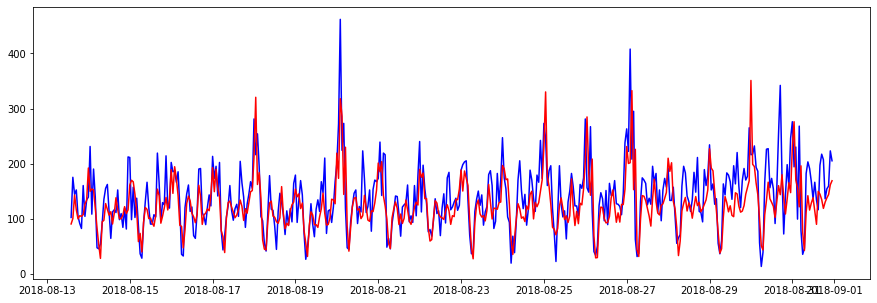

In [30]:
plt.figure(figsize=(15,5))
plt.plot(target_test.index, target_test, 'b-', target_test.index, predict_cbr,'r-')
plt.show()

## Общий вывод

- Подготовили данные:
    - Выгрузили данные
    - Отсортировали индексы
    - Ресемплировали данные по одному часу
    - Данные в таблице: с 1 марта 2018 года по 31 августа 2018 года
    - Пропусков нет
    - Всего один признак: num_orders
    - Временной интервал: 10 минут.
    - Даты и время расположены в хронологическом порядке
    
- Проанализировали данные:
    - Разложили данные на тренд, сезонность и остаток
    - Изучили интервалы: за весь период, за последний месяц, за последнюю неделю и последние 2 дня.
        - trend
        За все время: спрос на такси в летние месяцы растет, относительно весенних.
        За последний месяц: Спрос растет к концу месяца. Окончание сезона отпусков.
        За последнюю неделю: Высокий спрос в сб, пн и последние дни августа (30 и 31го). Окончание сезона отпусков и летних каникул.
        - Seasonality
        Сезонность заметна во все периоды.
        - Residuals
        Во всех периодах прослеживаются пики роста спроса.

- Написали функцию для создания признаков.

- Разделим данные на выборки. Сделали тестовую выборку размером 10% от исходных данных

- Обучили разные модели
    - Для каждой модели подобрали лучшие значения гиперпараметров.

- Протестировали модели и сравнили результаты.

- В качестве лучшей модели предложена CatBoostRegressor. rmse на train 27.11, на test 45.8